# 1. Download the MNIST Dataset

In [ ]:
import torch
from torchvision import datasets, transforms

# Step 1: Download the MNIST dataset and apply necessary transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download training and test sets
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# 2. Prepare Data

## Introduce The MNIST Dataset


*   Dataset Size: MNIST has 60,000 training images and 10,000 test images
*   Number of Classes: There are 10 classes, one for each digit (0-9).
*   Image Dimensions: Each image is 28x28 pixels in grayscale.


## Create a Dataset and DataLoader

In [ ]:
from torch.utils.data import DataLoader

# Create DataLoader for training and test data
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

## Preprocess the Data

 Deep learning models in PyTorch require input data to be in the form of tensors. Converting the image to a tensor allows it to be used for further computations in the model. The normalization is also done so that the model is easier to work with.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize with mean and std deviation of 0.5
])

## Visualize the Processed Data

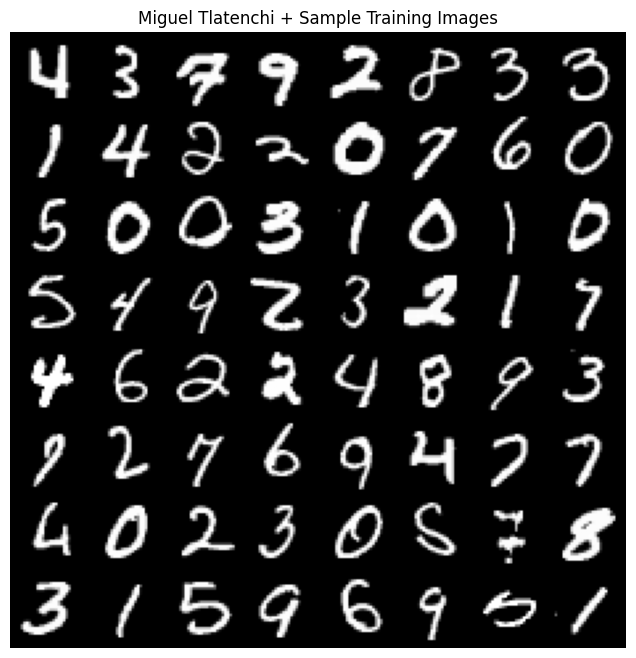

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

# show some images from the batch
sample_batch = next(iter(train_loader))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Miguel Tlatenchi + Sample Training Images")
plt.imshow(np.transpose(make_grid(sample_batch[0], padding=1, normalize=True),(1,2,0)));

# 3. Build a CNN Model

## Define the Model Structure

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Define layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
model = CNNModel()

## Set Up the Trainer

In [ ]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Summerize the Model

In [ ]:
from torchsummary import summary

# Display model summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Linear-5                  [-1, 128]         401,536
            Linear-6                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 1.61
Estimated Total Size (MB): 1.97
----------------------------------------------------------------


## Train the Model

In [ ]:
# Training loop
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5):
    train_losses = []  # Store training loss per epoch
    val_losses = []    # Store validation loss per epoch
    train_accuracies = []  # Store training accuracy per epoch
    val_accuracies = []    # Store validation accuracy per epoch

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            optimizer.zero_grad()  # Reset gradients
            outputs = model(images)
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()  # Accumulate batch loss

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))  # Store epoch loss
        train_accuracies.append(correct_train / total_train)  # Store accuracy

        # Validation phase (no gradient updates)
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calculate validation accuracy
                _, predicted = torch.max(outputs, 1)  # Get predicted class
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(test_loader))  # Store validation loss
        val_accuracies.append(correct_val / total_val)  # Store accuracy

        print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_losses[-1]:.4f} - Validation Loss: {val_losses[-1]:.4f}")
        print(f"Training Accuracy: {train_accuracies[-1]:.4f} - Validation Accuracy: {val_accuracies[-1]:.4f}")

    return train_losses, val_losses,train_accuracies, val_accuracies  # Return losses for visualization later

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer)

Epoch 1/5 - Training Loss: 0.0023 - Validation Loss: 0.0451
Training Accuracy: 0.9993 - Validation Accuracy: 0.9927
Epoch 2/5 - Training Loss: 0.0034 - Validation Loss: 0.0486
Training Accuracy: 0.9988 - Validation Accuracy: 0.9921
Epoch 3/5 - Training Loss: 0.0031 - Validation Loss: 0.0430
Training Accuracy: 0.9992 - Validation Accuracy: 0.9922
Epoch 4/5 - Training Loss: 0.0022 - Validation Loss: 0.0500
Training Accuracy: 0.9994 - Validation Accuracy: 0.9909
Epoch 5/5 - Training Loss: 0.0027 - Validation Loss: 0.0419
Training Accuracy: 0.9990 - Validation Accuracy: 0.9933


# 4. Visualize and Evaluation

## Training Loss Over Epochs

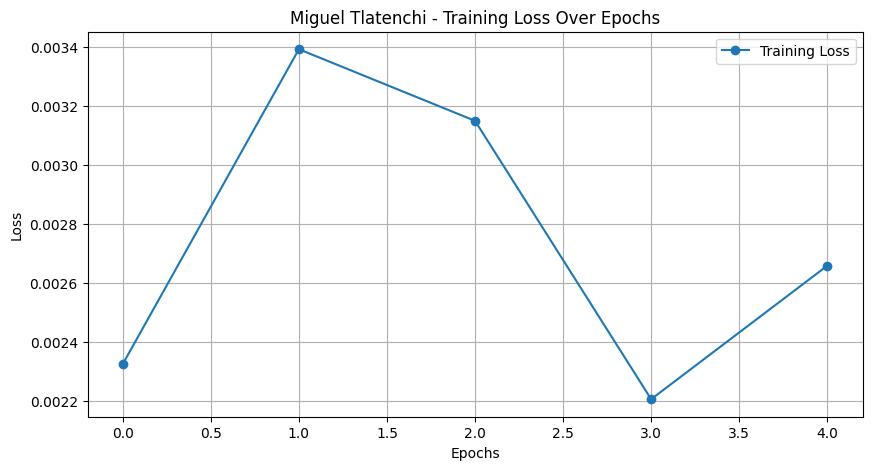

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Miguel Tlatenchi - Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

The graph shows that the loss initially increases which would indicate that the learning is not performing as expected. However, there is a drop in the loss wich indieciates that the learning is effective. Since there are only 4 epochs, detailed information may not be derived but it can be seen that the learning is effective overall.

## Validation Accuracy Over Epochs

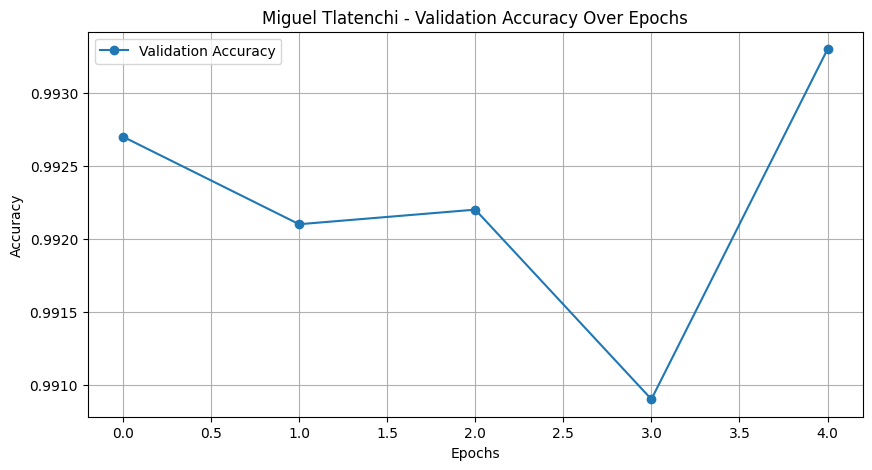

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label="Validation Accuracy",marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Miguel Tlatenchi - Validation Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()

 It can be seen that there is a steady decrease in validation accuracy which could indicate overfitting, where the model is memorizing the training data rather than generalizing well to new data. However, there seems to be a spike in accuracy in the fourth epoch which could indicate that the model is now generalizing well to new data and is improving its ability to make correct predictions.

## Visualizing Sample Predictions

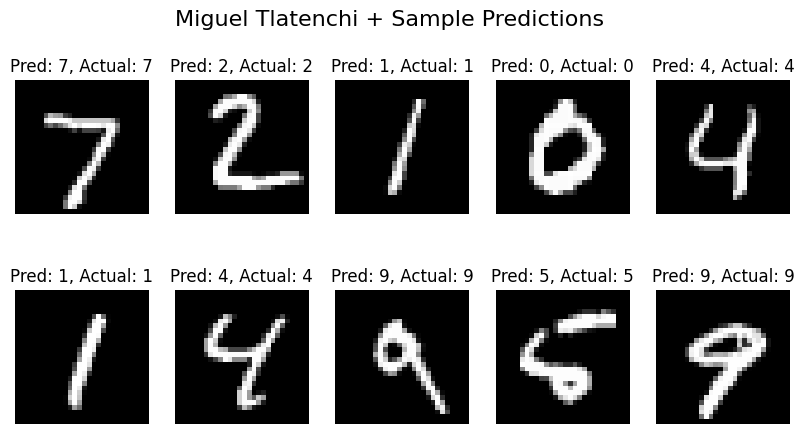

In [ ]:
import torch

# Get a batch from the test set
data_iter = iter(test_loader)
images, labels = next(data_iter)

# Get model predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)  # Get predicted class

# Plot the images with predicted and actual labels
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("Miguel Tlatenchi + Sample Predictions", fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap="gray")  # Convert tensor to image
    ax.set_title(f"Pred: {preds[i].item()}, Actual: {labels[i].item()}")
    ax.axis("off")

plt.show()

This visualization allows you to visually inspect how well the model is performing on test data, identify misclassifications, and gain insights into its strengths and weaknesses. The correct predictions show the model's ability to generalize, while the misclassifications may highlight the need for further improvements. Therefore, the visualization shows that its able to make correct predictions, which indicates that the model has a good ability to generalize.

## Validation Loss Over Epochs

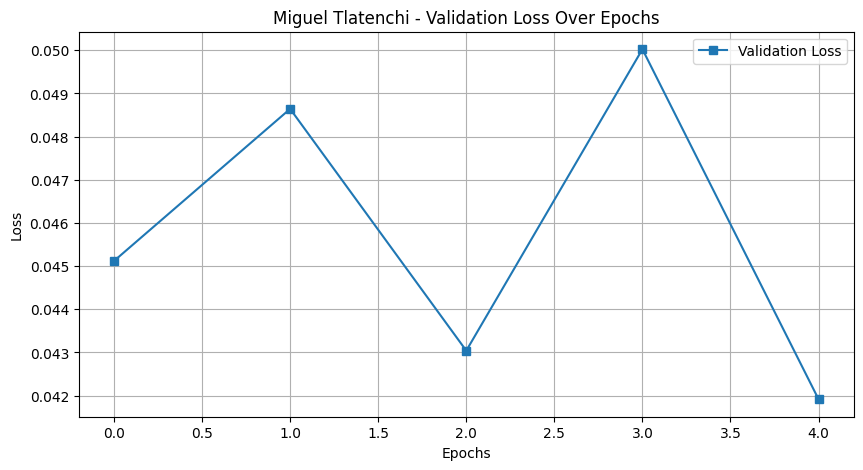

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(val_losses, label="Validation Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Miguel Tlatenchi - Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

The visualization shows that there were fluctuations, but then it suddenly dropped in the fourth epoch. Based on the matrix and sample predictions, we can infer that the model does perform well. However, this does show that the model may be overfitting.

##  Confusion Matrix

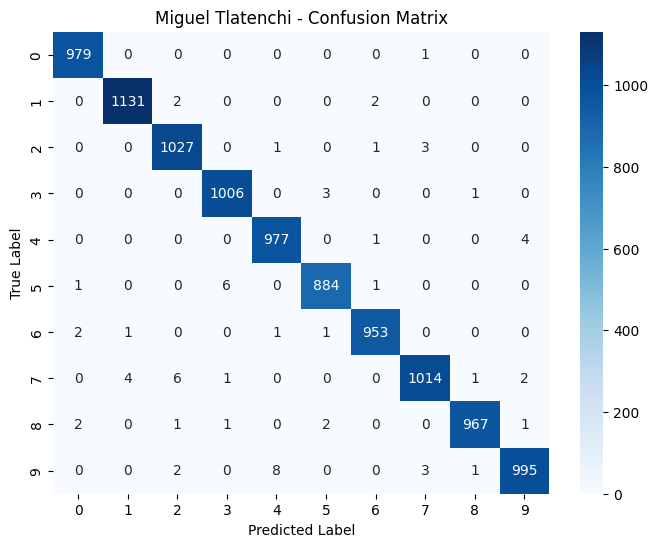

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Compute predictions for the entire test set
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Miguel Tlatenchi - Confusion Matrix")
plt.show()

The confusion matrix shows that the model is very accurate when making predictions. It seems that the model rarely predicts incorrectly and demonstrates that the model is performing very well.

# 5. Save Model

In [ ]:
import torch

# Assuming 'model' is your trained model
torch.save(model.state_dict(), 'model.pth')